# Convolutional Neural Network using an Optimized Backpropagation Technique
It has been observed that training CNNs using vanilla backprogatation doesn't ensure good performance, since the objjective function is not close to the global minimum. Attempts to improve this can be made by ensuring that the gradient optimization technique tries to accurately model attempts at moving to the global minimum, despite continual changes to the gradients and the Network parameters.

This experiment attempts to demonstrate the working of two commonly used gradient descent optimizers during the backpropagation process.

We consider two optimizers, namely the:
* AdaDelta Optimizer
* RMSProp Optimizer

We shall compare the performance of these two well studied optimizers, to verify that the optimized backpropagation technique brings us very good validation results.

## Dataset Used
We will be using the **COIL-100** Dataset, consisting of exactly 100 images, each having 72 augmentations. This technique of data augmentation is necessary, since the original dataset of 100 immages is too small to generalize well.

The dataset resides in the `./dataset/coil-100` directory. We'll be using a generator to generate images and load it onto the main training loop.

In [0]:
import pandas as pd
import numpy as np
import glob
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Conv2D, AveragePooling2D, Flatten, Dropout, Reshape

from tensorflow.python.framework.ops import disable_eager_execution

# Disable eager execution
disable_eager_execution()

# Batch Generator
This is a function which generates images in a batch-wise manner, specified by the batch size. While this is not required in this problem, since we could load the entire dataset at once into memory, it is still a good practice to used similar functions, especially if your dataset cannot fit into memory.

This loads images from `directory`, and splits it into **training_images: validation_images** at the default ratio of `0.7:0.3`

We associate a label for each image, and the labels are also generated along with the images.

In [0]:
def generate_images(directory, batch_size, labels, shuffle, target_size, rescale=1./255, validation_split=0.3, fmt='png', train=True):
    # Batch Generator -> Generates Numpy arrays from corresponding images after scaling
    if not isinstance(target_size, tuple):
        raise TypeError("Expected Tuple")
    assert validation_split <= 0.5
    
    data_path = pathlib.Path(directory)
    images = list(data_path.glob("*." + fmt))
    num_images = len(images)
    
    # A Label for each image
    if train is True:
        print(labels.shape[0], num_images)
    assert num_images == labels.shape[0]

    idx = 0

    images = np.array(images)
    inds = np.arange(num_images)
    
    if shuffle:
        np.random.shuffle(inds)
        images, labels = images[inds], labels[inds]
        # random.shuffle(images)
    
    val_size = math.ceil(batch_size * (validation_split))
    train_size = batch_size - val_size
    
    while True:
        image_batch_train = np.zeros((train_size,) + target_size, dtype='float') # target_size is already a tuple
        label_batch_train = np.zeros((train_size, labels.shape[1]))
        image_batch_val = np.zeros((val_size,) + target_size, dtype='float')
        label_batch_val = np.zeros((val_size, labels.shape[1]))
        for i in range(train_size):
            if idx == num_images:
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_train[i] = image
            label_batch_train[i] = labels[idx]
            idx += 1
        for i in range(train_size, batch_size):
            if idx == num_images:
                # Reset index and shuffle if we reach the end of the dataset
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_val[i - train_size] = image
            label_batch_val[i - train_size] = labels[idx]
            idx += 1

        if train is True:
            print(f'Training Batch Size = {train_size}')
            print(f'Validation Batch Size = {batch_size - train_size}')
        
        # Yield a generator for both the training as well as the validation set of images
        yield image_batch_train, label_batch_train, image_batch_val, label_batch_val

* This helper function converts a numpy `ndarray` to a `PIL` image, for visualizing any output. While this is not directly used in the final experiment, we used this to verify that we were getting the correct outputs from our Network.

In [0]:
def numpy_to_img(normalized_img, scale=255.0):
    # The original array is normalized, so scale it again
    # RGB Mode expects uint8
    image = Image.fromarray((normalized_img * scale).astype('uint8'))
    return image

# One-Hot-Encoding Trick
For small datasets, the One Hot Encoding trick converts a scalar label into a vector. This is quite useful, since we can directly correlate the softmax output to the one-hot-vector, having the same dimensions. While this does not work for large datasets, we can take advantage of this technique quite clearly in our experiments.

* Originally, the labels were simply a number between 0 to 100. Since the number of images are small, we can directly convert them into a one-hot encoding format. This `one_hot_encoder()` function vectorizes a scalar label, and returns the one hot encoding of the labelled dataset.

In [0]:
def one_hot_encoder(label_dataset):
  """
    Takes a labelled dataset of the form: [ 0 0 0 ... 1 1 1 ... 100 100 100 ... ]
    and returns a one-hot encoding representation of the labelled data
  """
  unique_labels = np.unique(label_dataset)
  one_hot_labels = np.zeros((label_dataset.shape[0], unique_labels.shape[0]))
  label_dataset = np.repeat(label_dataset, unique_labels.shape[0]).reshape(-1, unique_labels.shape[0])
  one_hot_labels[np.where(label_dataset == unique_labels)] = 1
  return one_hot_labels

# Generating the Models

We have two models to compare: one using the Adadelta optimizer, and the other, using the RMSProp Optimizer.
The models are almost the same. The main structure difference is that the RMSProp has 50 weights for the second-last Dense layer, while the Adadelta has 100. Other that that, there are some hyperparameters specific to both the models.

Due to this, plus the fact that the RMSProp Optimizer uses a constant learning rate, we would generally expect the RMSProp model to converge faster than the Adadelta, although the performance wouldn't differ by much.

In [0]:
def generate_model(optimizer):
    if optimizer == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(
            learning_rate=0.02, rho=0.96, epsilon=1e-03, name='Adadelta')
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(16, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    elif optimizer == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, name='RMSprop')
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(16, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    else:
        raise ValueError("Only Adadelta and RMSprop optimizers are allowed")

# The Main Function


In [0]:
if __name__ == '__main__':
    data_dir = os.path.join(os.getcwd(), 'dataset', 'coil-100')
    data_path = pathlib.Path(data_dir)

    # Path to all images
    images = pathlib.Path(data_dir).glob("*.png")
    image_data = list(images)

    CLASS_LABELS = list([int(''.join(item.name.split('_')[0].lstrip('obj'))) for item in image_data])
    CLASS_LABELS = np.array((CLASS_LABELS))
    CLASS_LABELS = one_hot_encoder(CLASS_LABELS)
    
    # Define parameters for batch generation
    BATCH_SIZE = len(image_data)
    IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
    NUM_CHANNELS = 3 # RGB Image has 3 channels

    # Use the batch generator. This outputs (train_images, val_images)
    gen = generate_images(directory=str(data_path), batch_size=BATCH_SIZE,
                            labels=CLASS_LABELS,
                            shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                            validation_split=0.3)

    # Example generation. This generates a single batch of training and validation images
    batch_train, label_train, batch_val, label_val = next(gen)

7200 7200
Training Batch Size = 5040
Validation Batch Size = 2160


# Generate the Adadelta Model

In [0]:
model = generate_model('Adadelta')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

# Fit the model on the Dataset

In [0]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 4.3440 - accuracy: 0.0575 - val_loss: 3.7026 - val_accuracy: 0.1597
Epoch 2/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 2.5696 - accuracy: 0.3776 - val_loss: 1.8711 - val_accuracy: 0.5477
Epoch 3/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 1.0084 - accuracy: 0.7474 - val_loss: 0.8069 - val_accuracy: 0.7977
Epoch 4/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 0.3954 - accuracy: 0.8988 - val_loss: 0.3955 - val_accuracy: 0.8968
Epoch 5/20
5040/5040 [==============================] - 30s 6ms/sample - loss: 0.1695 - accuracy: 0.9560 - val_loss: 0.3411 - val_accuracy: 0.9250
Epoch 6/20
5040/5040 [==============================] - 29s 6ms/sample - loss: 0.0825 - accuracy: 0.9802 - val_loss: 0.0839 - val_accuracy: 0.9819
Epoch 7/20
5040/5040 [==============================] - 28s 6ms/sample

In [0]:
model.save_weights('adadelta_model_weights.h5')

# Plot results (Adadelta)

# Experiment 1 (`batch_size = 50`)

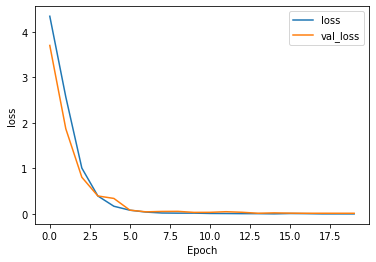

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [0]:
print(test_loss, test_acc)

0.015015381692770731 0.99583334


In [0]:
# Generate the RMSprop Model

In [0]:
model = generate_model('RMSprop')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

# Fit the Model using RMSprop Optimizer

In [0]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 2.5203 - accuracy: 0.4157 - val_loss: 0.7158 - val_accuracy: 0.8218
Epoch 2/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 0.4480 - accuracy: 0.8810 - val_loss: 0.2587 - val_accuracy: 0.9250
Epoch 3/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 0.1780 - accuracy: 0.9512 - val_loss: 0.1160 - val_accuracy: 0.9727
Epoch 4/20
5040/5040 [==============================] - 28s 6ms/sample - loss: 0.0920 - accuracy: 0.9746 - val_loss: 0.3321 - val_accuracy: 0.9449
Epoch 5/20
5040/5040 [==============================] - 30s 6ms/sample - loss: 0.0698 - accuracy: 0.9825 - val_loss: 0.0226 - val_accuracy: 0.9917
Epoch 6/20
5040/5040 [==============================] - 30s 6ms/sample - loss: 0.0409 - accuracy: 0.9885 - val_loss: 0.0202 - val_accuracy: 0.9940
Epoch 7/20
5040/5040 [==============================] - 28s 6ms/sample

In [0]:
model.save_weights('rmsprop_model_weights.h5')

# Plot Results (RMSprop)

# Experiment 2 (`batch_size = 50`)

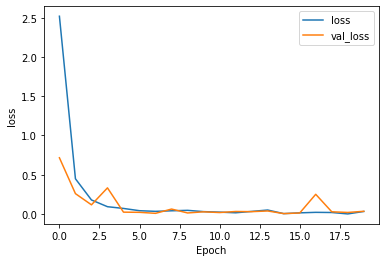

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [0]:
print(test_loss, test_acc)

0.03345360735143762 0.9912037


# Load the PreTrained Weights
This function loads the previously trained weights for both the models, from the files `adadelta_model_weights.h5` and `rmsprop_model_weights.h5`.

You can load the model from these weights and test them on sample images.

In [0]:
def load_model(type):
    if type == "Adadelta":
        model = generate_model("Adadelta")
        model.load_weights('adadelta_model_weights.h5')
        return model
    elif type == "RMSprop":
        model = generate_model("RMSprop")
        model.load_weights('rmsprop_model_weights.h5')
        return model
    else:
        raise ValueError("Only Adagrad and RMSprop models supported")

# Test the Model
This function tests the model on some sample images randomly taken from the batch generator function. This returns the prediction for every sample test image, along with their corresponding labels and images. We can use this to verify the correctness of our model.

In [0]:
def test_model(model, data_path, num_samples):
    gen = generate_images(directory=str(data_path), batch_size=num_samples,
                            labels=CLASS_LABELS,
                            shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                            validation_split=0, train=False)
    # We don't need any validation images, since this is test-time
    test_images, test_labels, _, _ = next(gen)
    # Make the prediction using the model
    predictions = model.predict(test_images)

    test_images = test_images.reshape(test_images.shape[0], -1)

    def convert_to_image(img_arr, target_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), scale=255.0):
        # The original array is normalized, so scale it again
        # RGB Mode expects uint8
        image = Image.fromarray((img_arr.reshape(target_shape) * scale).astype('uint8'))
        return image
    
    return np.apply_along_axis(np.argmax, arr=predictions, axis=1), np.apply_along_axis(convert_to_image, arr=test_images, axis=1), test_labels

## Load and Test the $Adadelta$ model

In [0]:
model = load_model('Adadelta')
predictions, test_images, test_labels = test_model(model, data_path, num_samples=10)

Predicted Label: 79
Actual Label: 79


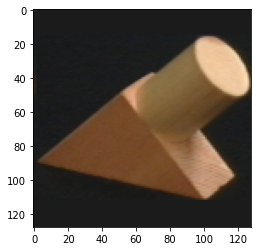

In [0]:
# Example Image for testing the Model
print(f"Predicted Label: {predictions[0]}")
print(f"Actual Label: {np.argmax(test_labels[0])}")
plt.imshow(test_images[0])

## Load and Test the $RMSprop$ Model:

In [0]:
model = load_model('RMSprop')
predictions, test_images, test_labels = test_model(model, data_path, num_samples=10)

Predicted Label: 90
Actual Label: 90


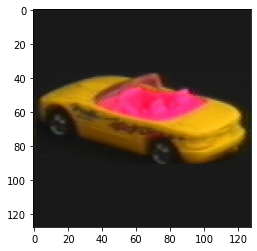

In [0]:
# Example Image for testing the Model
print(f"Predicted Label: {predictions[0]}")
print(f"Actual Label: {np.argmax(test_labels[0])}")
plt.imshow(test_images[0])

# Conclusion

As you can observe, the validation accuracy of both the optimizers are very similar, indicating that the reach very similar minima.

We can see that overall, AdaDelta can possibly generalize better than RMSProp for our small dataset, since $Accuracy_{adadelta} = 0.9958$, while $Accuracy_{rmsprop} = 0.9912$.

However, the loss of `AdaDelta` ($Loss_{adadelta}$) = 0.015, while the loss of `RMSProp` ($Loss_{rmsprop}$) = 0.033. This means that overall, the AdaDelta optimizer has reached a point closer to the global minima, as compared to RMSProp. This better converge has a cost, with a higher number of epochs required to tackle the vanishing gradients problem, when the gradients are close to zero. RMSProp does not face this issue, since it has a constant learning rate $\eta = 0.001$.

While the applicability of these two optimizers varies depending on the problem, for our small scale CNN, we indeed observed that AdaDelta fares the best among the two, although we set a do a lot of epochs in training to beat the RMSProp optimizer.